In [44]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np


In [45]:
# 将数据集使用滑动窗口方法制作成监督学习
def series_to_supervised(df,n_in=336, n_out=336):   #传入的data应当是一个frame
    n_vars = df.shape[1]         #获取变量数
    df=DataFrame(df)
    cols, names = [], []
    
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names

    return agg

In [46]:
#读取数据集
dataset_train=pd.read_csv("train_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
dataset_test=pd.read_csv("test_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
dataset_val=pd.read_csv("validation_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引


values_train = dataset_train.values
values_test = dataset_test.values
values_val = dataset_val.values



C:\Users\12204\AppData\Local\Temp\ipykernel_4168\1782723478.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_train=pd.read_csv("train_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
C:\Users\12204\AppData\Local\Temp\ipykernel_4168\1782723478.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_test=pd.read_csv("test_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
C:\Users\12204\AppData\Local\Temp\ipykernel_4168\1782723478.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and wi

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(values_train)
scaled_test = scaler.fit_transform(values_test)
scaled_val = scaler.fit_transform(values_val)

# scale         #归一化

In [48]:
reframed_train = series_to_supervised(scaled_train, 336, 336)
reframed_test = series_to_supervised(scaled_test, 336, 336)
reframed_val = series_to_supervised(scaled_val, 336, 336)


reframed_train.shape

(8640, 4704)

In [49]:
# reframed = reframed[:]
# reframed.shape

In [50]:
n_in = 336
n_out=336
n_vars=7
col_names = ['HUFL','HULL','MUFL','MULL','LUFL','LULL','OT']
contain_vars = []
for i in range(n_in,0,-1):
    contain_vars += [('%s(t-%d)' % (col_names[j], i)) for j in range(0,n_vars)]  
for i in range(0, n_out):
    contain_vars += [('%s(t+%d)' % (col_names[j], i)) for j in range(0,n_vars)]  

len(contain_vars)

reframed_train.columns=contain_vars
reframed_test.columns=contain_vars
reframed_val.columns=contain_vars

import copy
data_train = copy.deepcopy(reframed_train)
data_test = copy.deepcopy(reframed_test)
data_val = copy.deepcopy(reframed_val)


    #修改列名
    # contain_vars = []
    # for i in range(1,n_in+1):
    #     contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(n_vars)]
    # for i in range(n_vars):
    #     contain_vars += [('%s(t+%d)' % (col_names[i], j)) for j in range(0,n_out-1)]   
    # data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1,n_out)]
    # #分隔数据集，分为训练集和测试集
    # values = data.values

In [51]:
data_train.shape

(8640, 4704)

In [52]:
pd.set_option('display.max_columns', None)
trainn = data_train.values
vall = data_val.values
testt = data_test.values

# data.shape
# data.values
# values=data.values
# data
# n_train = round(data.shape[0]*0.6)
# n_val = round(data.shape[0]*0.2)
# trainn = values[:n_train, :]
# vall = values[n_train:n_train+n_val, :]
# testt = values[n_train+n_val:, :]





train_X, train_y = trainn[:, :n_in*n_vars], trainn[:, n_in*n_vars:]
val_X, val_y = vall[:, :n_in*n_vars], vall[:, n_in*n_vars:]
test_X, test_y = testt[:, :n_in*n_vars], testt[:, n_in*n_vars:]

train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
# train_y = train_y.reshape((train_y.shape[0], n_in, n_vars))

val_X = val_X.reshape((val_X.shape[0], n_in, n_vars))
# val_y= val_y.reshape((val_y.shape[0], n_in, n_vars))

test_X =test_X.reshape((test_X.shape[0], n_in, n_vars))
# test_y =test_y.reshape((test_X.shape[0], n_in, n_vars))


#将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
# train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
# test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
# return scaler, data, train_X, train_y, test_X, test_y, dataset


In [53]:

train_X.shape
trainn.shape
train_X[-1]

array([[0.63033635, 0.31149548, 0.70377467, ..., 0.36245456, 0.15168668,
        0.40589374],
       [0.67930092, 0.45900303, 0.75713251, ..., 0.34229371, 0.14489473,
        0.3876455 ],
       [0.65559697, 0.42620544, 0.7240201 , ..., 0.33226836, 0.14489473,
        0.38201529],
       ...,
       [0.65559697, 0.30602921, 0.69732823, ..., 0.50336015, 0.17251529,
        0.4929822 ],
       [0.63979433, 0.32242801, 0.69271994, ..., 0.4933348 , 0.15870501,
        0.50140756],
       [0.65401672, 0.3388268 , 0.71296537, ..., 0.47317397, 0.17930723,
        0.50983288]])

In [54]:
def fit_lstm(train_Xx,train_yy,val_Xx,val_yy, n_neurons=50, n_batch=72, n_epoch=10, loss='mae', optimizer='adam', repeats=1):
    train_X = train_Xx
    train_y = train_yy
    val_X = val_Xx
    val_y = val_yy

    model_list = []
    for i in range(repeats):
        #设计神经网络
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(val_X, val_y), verbose=0, shuffle=False)
        #画出学习过程
        p1 = pyplot.plot(history.history['loss'], color='blue', label='train')
        p2 = pyplot.plot(history.history['val_loss'], color='yellow',label='val')
        #保存model
        model_list.append(model)
    pyplot.legend(["train","test"])
    pyplot.show()
    return model_list

In [55]:
def lstm_predict(model, scaler,test_X,test_y):
    # 做出预测
    yhat = model.predict(test_X)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

In [56]:
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

In [57]:
#以原始数据为背景画出预测数据
def plot_forecasts(series, forecasts):
    #用蓝色画出原始数据集
    pyplot.plot(series.values)
    n_seq = len(forecasts[0])
    #用红色画出预测值
    for i in range(1,len(forecasts)+1):
        xaxis = [x for x in range(i, i+n_seq+1)]
        yaxis = [float(series.iloc[i-1,0])] + list(forecasts[i-1])
        pyplot.plot(xaxis, yaxis, color='red')
    #展示图像
    pyplot.show()

In [58]:
train_X.shape

(8640, 336, 7)

In [59]:
train_y=train_y.reshape(train_y.shape[0],336,7)
val_y=val_y.reshape(val_y.shape[0],336,7)
train_y.shape
                  
train_X = train_X[336:]
train_y = train_y[:-336]
val_X=val_X[336:]
val_y = val_y[:-336]
# train_y[-96:]



In [60]:
train_X.shape
train_y[-1]
# train_y.shape
# test_X.shape
val_y

array([[[0.72584233, 0.48197713, 0.7871379 , ..., 0.21111838,
         0.14053173, 0.60443477],
        [0.70523376, 0.47747142, 0.76880775, ..., 0.18718115,
         0.13212154, 0.59330825],
        [0.66877249, 0.43241425, 0.74952237, ..., 0.17527797,
         0.13212154, 0.59330825],
        ...,
        [0.72742761, 0.21170141, 0.74402332, ..., 0.42236752,
         0.10743353, 0.75767178],
        [0.76386524, 0.25675857, 0.7871379 , ..., 0.38247219,
         0.12398263, 0.77715302],
        [0.76069467, 0.28379287, 0.79632879, ..., 0.31079137,
         0.0577862 , 0.78273611]],

       [[0.70523376, 0.47747142, 0.76880775, ..., 0.18718115,
         0.13212154, 0.59330825],
        [0.66877249, 0.43241425, 0.74952237, ..., 0.17527797,
         0.13212154, 0.59330825],
        [0.72267178, 0.48648284, 0.7862343 , ..., 0.16337475,
         0.13212154, 0.56266085],
        ...,
        [0.76386524, 0.25675857, 0.7871379 , ..., 0.38247219,
         0.12398263, 0.77715302],
        [0.7

In [71]:

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(200,activation='relu',input_shape=(336, 7),return_sequences=True))
model.add(LSTM(50,activation='relu',input_shape=(336, 7),return_sequences=True))
model.add(TimeDistributed(Dense(7)))
model.compile(loss='mae', optimizer='adam')
hst = model.fit(train_X, train_y, epochs=15, batch_size=8, validation_data=(val_X, val_y), verbose=1, shuffle=False)

# 0.012,0.0026
# 200 - 50 , 0.0041,0.014



Epoch 1/15
1038/1038 [==============================] - 111s 106ms/step - loss: 0.0386 - val_loss: 0.0505
Epoch 2/15
1038/1038 [==============================] - 111s 107ms/step - loss: 0.0140 - val_loss: 0.0249
Epoch 3/15
1038/1038 [==============================] - 110s 106ms/step - loss: 0.0112 - val_loss: 0.0221
Epoch 4/15
1038/1038 [==============================] - 109s 105ms/step - loss: 0.0088 - val_loss: 0.0187
Epoch 5/15
1038/1038 [==============================] - 109s 105ms/step - loss: 0.0082 - val_loss: 0.0197
Epoch 6/15
1038/1038 [==============================] - 113s 109ms/step - loss: 0.0068 - val_loss: 0.0176
Epoch 7/15
1038/1038 [==============================] - 113s 109ms/step - loss: 0.0062 - val_loss: 0.0182
Epoch 8/15
1038/1038 [==============================] - 111s 107ms/step - loss: 0.0057 - val_loss: 0.0161
Epoch 9/15
1038/1038 [==============================] - 112s 107ms/step - loss: 0.0045 - val_loss: 0.0142
Epoch 10/15
1038/1038 [=======================

In [72]:
v = model.predict(test_X)

93/93 [==============================] - 7s 78ms/step


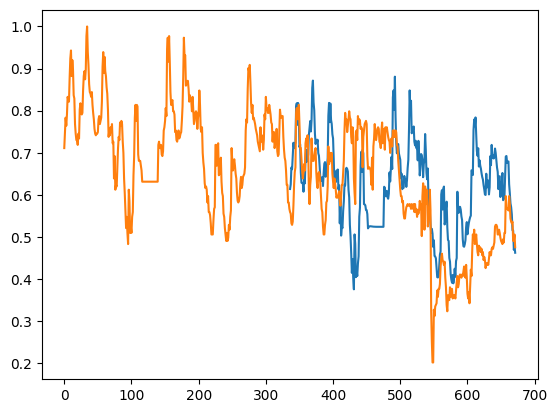

In [137]:

pyplot.figure()

test_y=test_y.reshape(test_y.shape[0],336,7)
wind =484
iddx = 6
combined_line = list(    test_y[wind-336][:, iddx])  + list(test_y[wind][:, iddx])
pyplot.plot([None]*336+   list(v[wind][:,iddx]-0.1))        #2016   3214
pyplot.plot(combined_line)
pyplot.show()


In [79]:
model2 = Sequential()
model2.add(LSTM(200,activation='relu',input_shape=(336, 7),return_sequences=True))
model2.add(LSTM(50,activation='relu',input_shape=(336, 7),return_sequences=True))
model2.add(TimeDistributed(Dense(7)))
model2.compile(loss='mse', optimizer='adam')
hst = model2.fit(train_X, train_y, epochs=15, batch_size=8, validation_data=(val_X, val_y), verbose=1, shuffle=False)


Epoch 1/15
1038/1038 [==============================] - 114s 109ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 2/15
1038/1038 [==============================] - 112s 108ms/step - loss: 3.4369e-04 - val_loss: 0.0013
Epoch 3/15
1038/1038 [==============================] - 112s 107ms/step - loss: 5.0217e-04 - val_loss: 0.0010
Epoch 4/15
1038/1038 [==============================] - 111s 107ms/step - loss: 1.4006e-04 - val_loss: 6.0711e-04
Epoch 5/15
1038/1038 [==============================] - 114s 109ms/step - loss: 4.0129e-04 - val_loss: 7.0469e-04
Epoch 6/15
1038/1038 [==============================] - 113s 109ms/step - loss: 9.0467e-05 - val_loss: 4.7842e-04
Epoch 7/15
1038/1038 [==============================] - 120s 115ms/step - loss: 1.0142e-04 - val_loss: 4.8259e-04
Epoch 8/15
1038/1038 [==============================] - 117s 112ms/step - loss: 1.2514e-04 - val_loss: 4.5440e-04
Epoch 9/15
1038/1038 [==============================] - 115s 110ms/step - loss: 4.2209e-05 - val_loss: 3

In [81]:
vvvvvvv = model2.predict(test_X)

93/93 [==============================] - 7s 73ms/step


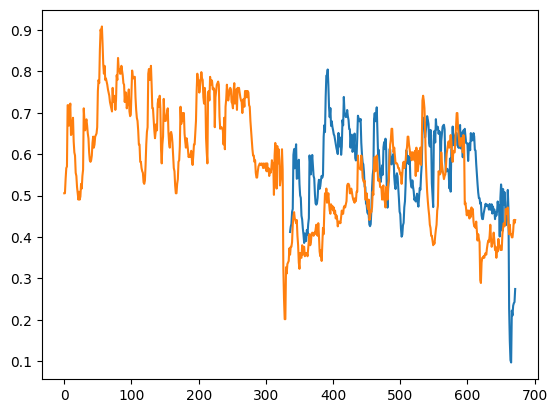

In [157]:
pyplot.figure()

test_y=test_y.reshape(test_y.shape[0],336,7)
wind =704
iddx = 6
combined_line = list(    test_y[wind-336][:, iddx])  + list(test_y[wind][:, iddx])
pyplot.plot([None]*336+   list(vvvvvvv[wind][:,iddx]-0.1))        #2016   3214
pyplot.plot(combined_line)
pyplot.show()